<a href="https://colab.research.google.com/github/Rukayat-spec/Algorithmic-Trading-in-Forex-Machine-Learning-Approaches-for-GBP-EUR-Profitability/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#Load the CSV file into a DataFrame


In [ ]:
df = pd.read_csv(r"/GBP_EUR_Pair_Historical_Data.csv")
print(df.head())

         Date    Open    High     Low   Close  Adj Close  Volume
0  2003-09-17  1.4271  1.4286  1.4237  1.4261     1.4261     0.0
1  2003-09-18  1.4261  1.4382  1.4239  1.4370     1.4370     0.0
2  2003-09-19  1.4368  1.4411  1.4333  1.4372     1.4372     0.0
3  2003-09-22  1.4354  1.4408  1.4331  1.4360     1.4360     0.0
4  2003-09-23  1.4360  1.4436  1.4341  1.4426     1.4426     0.0


In [ ]:
# Check the shape of the dataset
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} columns.')

The dataset contains 5402 rows and 7 columns.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5402 entries, 0 to 5401
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5402 non-null   object 
 1   Open       5373 non-null   float64
 2   High       5373 non-null   float64
 3   Low        5373 non-null   float64
 4   Close      5373 non-null   float64
 5   Adj Close  5373 non-null   float64
 6   Volume     5373 non-null   float64
dtypes: float64(6), object(1)
memory usage: 295.5+ KB


In [ ]:
# Display summary statistics
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.0
mean,1.242865,1.246882,1.238706,1.242842,1.242842,0.0
std,0.130321,0.130407,0.130163,0.130289,0.130289,0.0
min,1.015700,1.032400,1.015700,1.015700,1.015700,0.0
25%,1.145800,1.149510,1.141360,1.145690,1.145690,0.0
50%,1.181800,1.185800,1.177800,1.181700,1.181700,0.0
75%,1.350400,1.355800,1.344600,1.349400,1.349400,0.0
max,1.526200,1.529500,1.521400,1.526200,1.526200,0.0


In [ ]:
# Display the sum of null values for each column
print(df.isnull().sum())

Date          0
Open         29
High         29
Low          29
Close        29
Adj Close    29
Volume       29
dtype: int64


In [ ]:
# Remove rows with null values in any of the specified columns
df_cleaned = df.dropna(subset=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'])
print(df_cleaned)

            Date     Open     High     Low    Close  Adj Close  Volume
0     2003-09-17  1.42710  1.42860  1.4237  1.42610    1.42610     0.0
1     2003-09-18  1.42610  1.43820  1.4239  1.43700    1.43700     0.0
2     2003-09-19  1.43680  1.44110  1.4333  1.43720    1.43720     0.0
3     2003-09-22  1.43540  1.44080  1.4331  1.43600    1.43600     0.0
4     2003-09-23  1.43600  1.44360  1.4341  1.44260    1.44260     0.0
...          ...      ...      ...     ...      ...        ...     ...
5397  2024-05-24  1.17370  1.17479  1.1718  1.17370    1.17370     0.0
5398  2024-05-27  1.17380  1.17689  1.1735  1.17380    1.17380     0.0
5399  2024-05-28  1.17581  1.17689  1.1738  1.17581    1.17581     0.0
5400  2024-05-29  1.17562  1.17864  1.1741  1.17562    1.17562     0.0
5401  2024-05-30  1.17537  1.17615  1.1745  1.17543    1.17543     0.0

[5373 rows x 7 columns]


In [ ]:
print(f'The dataset contains {df_cleaned.shape[0]} rows and {df_cleaned.shape[1]} columns.')

The dataset contains 5373 rows and 7 columns.


In [ ]:
# Remove rows with missing values
print(df_cleaned.isnull().sum())

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
df_cleaned.describe()


,Open,High,Low,Close,Adj Close,Volume
count,5373.000000,5373.000000,5373.000000,5373.000000,5373.000000,5373.0
mean,1.242865,1.246882,1.238706,1.242842,1.242842,0.0
std,0.130321,0.130407,0.130163,0.130289,0.130289,0.0
min,1.015700,1.032400,1.015700,1.015700,1.015700,0.0
25%,1.145800,1.149510,1.141360,1.145690,1.145690,0.0
50%,1.181800,1.185800,1.177800,1.181700,1.181700,0.0
75%,1.350400,1.355800,1.344600,1.349400,1.349400,0.0
max,1.526200,1.529500,1.521400,1.526200,1.526200,0.0


In [ ]:
# Convert Date' column to datetime to ensure
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])

# Verify the conversion by checking the column datatypes
print(df_cleaned.dtypes)

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object


<ipython-input-18-44b2f0d00a9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])


# @title Default title text
choosing the close column for this analysis because it reflects the final price
 at which the asset was traded at the end of the trading day. It is often
seen as the most representative of the asset's value for that day because it
incorporates all the market activity and sentiment up until the market close.

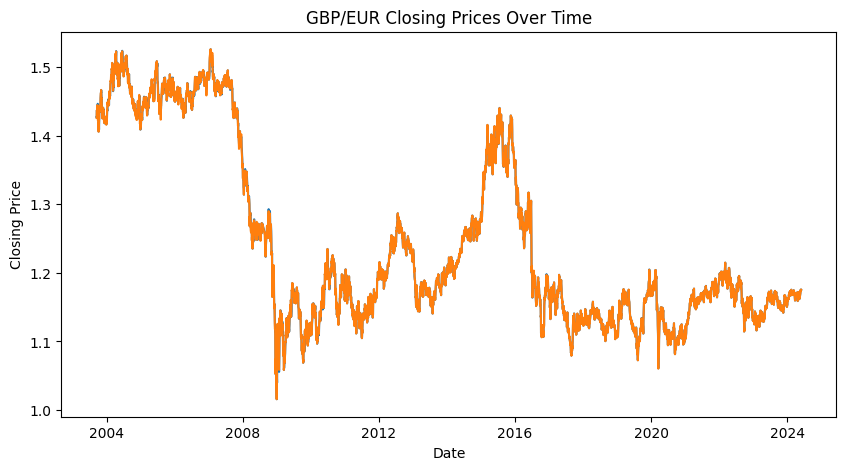

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_cleaned['Date'], df_cleaned['Open'])
plt.plot(df_cleaned['Date'], df_cleaned['Close'])
plt.title('GBP/EUR Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

The charts shows a sharp decrease between 2008 and 2009,2015 and 2017. The highest closing price seems to be around 2008.

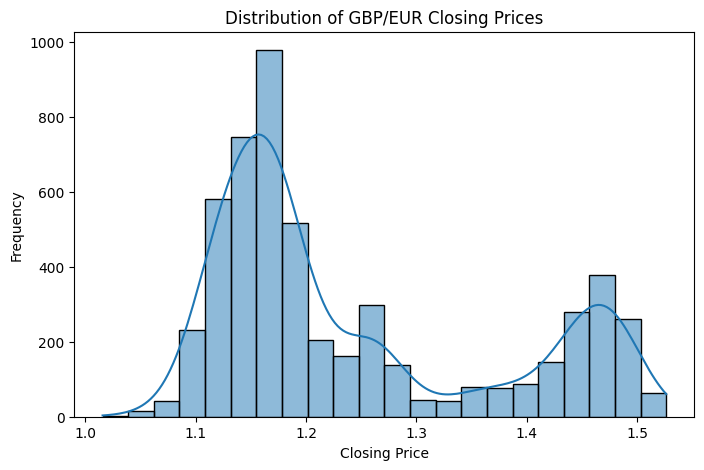

In [ ]:
# Creating a histo gram to understand the distribution of the dataset
"""Kernel Density Estimate(KDE) adds a smooth curve over the histogram, giving a
 continuous estimation of the probability density function of the data """

plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['Close'], kde=True)
plt.title('Distribution of GBP/EUR Closing Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

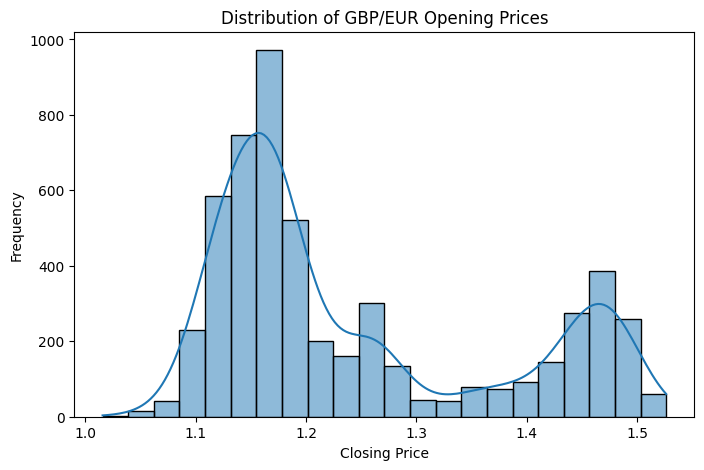

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['Open'], kde=True)
plt.title('Distribution of GBP/EUR Opening Prices')
plt.xlabel('Closing Price')
plt.ylabel('Frequency')
plt.show()

Both histograms show a bimodal distribution(2 peaks)

The first peak is between 1.1 and 1.2 and is slightly skewed to the right.
The second peak is between 1.4 and 1.5 closing price and appears to be more symmetric(tending to be normally distributed).

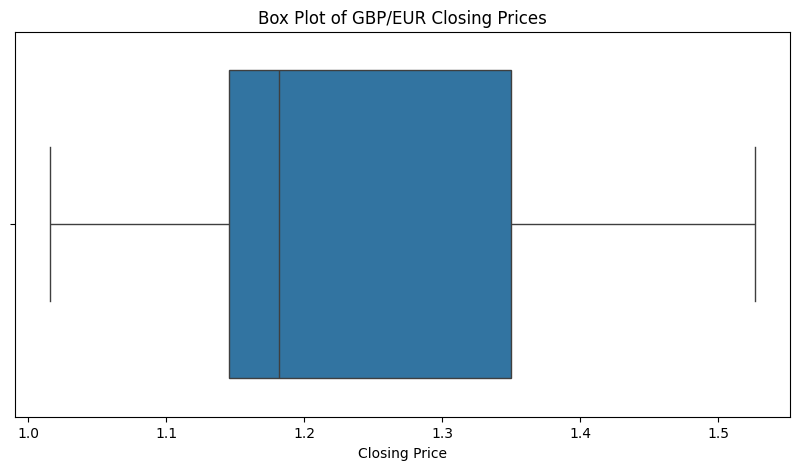

In [ ]:
#using box plot to visualise outliers in the dataset.
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_cleaned['Close'])
plt.title('Box Plot of GBP/EUR Closing Prices')
plt.xlabel('Closing Price')
plt.show()

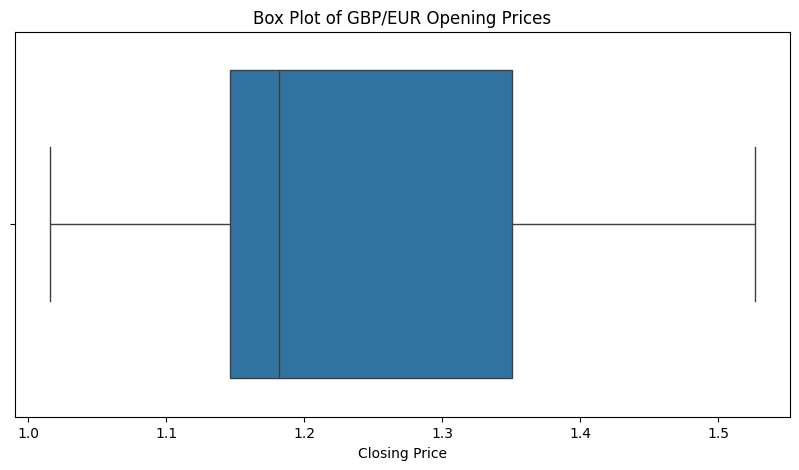

In [ ]:
#using box plot to visualise outliers in the dataset.
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_cleaned['Open'])
plt.title('Box Plot of GBP/EUR Opening Prices')
plt.xlabel('Closing Price')
plt.show()

In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_cleaned['Close'].quantile(0.25)
Q3 = df_cleaned['Close'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_cleaned[(df_cleaned['Close'] < lower_bound) | (df_cleaned['Close'] > upper_bound)]
print(f'Number of outliers: {len(outliers)}')
print(outliers)

Number of outliers: 0
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


In [ ]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_cleaned['Open'].quantile(0.25)
Q3 = df_cleaned['Open'].quantile(0.75)
IQR = Q3 - Q1

# Calculate the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = df_cleaned[(df_cleaned['Open'] < lower_bound) | (df_cleaned['Open'] > upper_bound)]
print(f'Number of outliers: {len(outliers)}')
print(outliers)

Number of outliers: 0
Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []


In [ ]:
from scipy import stats
# Z-Score Method
df_cleaned['Z_Score'] = np.abs(stats.zscore(df_cleaned['Close']))
threshold = 3
z_score_outliers = df_cleaned[df_cleaned['Z_Score'] > threshold]
print(df_cleaned)

           Date     Open     High     Low    Close  Adj Close  Volume  \
0    2003-09-17  1.42710  1.42860  1.4237  1.42610    1.42610     0.0   
1    2003-09-18  1.42610  1.43820  1.4239  1.43700    1.43700     0.0   
2    2003-09-19  1.43680  1.44110  1.4333  1.43720    1.43720     0.0   
3    2003-09-22  1.43540  1.44080  1.4331  1.43600    1.43600     0.0   
4    2003-09-23  1.43600  1.44360  1.4341  1.44260    1.44260     0.0   
...         ...      ...      ...     ...      ...        ...     ...   
5397 2024-05-24  1.17370  1.17479  1.1718  1.17370    1.17370     0.0   
5398 2024-05-27  1.17380  1.17689  1.1735  1.17380    1.17380     0.0   
5399 2024-05-28  1.17581  1.17689  1.1738  1.17581    1.17581     0.0   
5400 2024-05-29  1.17562  1.17864  1.1741  1.17562    1.17562     0.0   
5401 2024-05-30  1.17537  1.17615  1.1745  1.17543    1.17543     0.0   

       Z_Score  
0     1.406687  
1     1.490355  
2     1.491891  
3     1.482679  
4     1.533341  
...        ...  
5397

<ipython-input-26-6bb91e27d6ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Z_Score'] = np.abs(stats.zscore(df_cleaned['Close']))


In [ ]:
from sklearn.ensemble import IsolationForest

# Isolation Forest Method
iso_forest = IsolationForest(contamination=0.01)
df_cleaned['Outlier'] = iso_forest.fit_predict(df_cleaned[['Close']])
iso_forest_outliers = df_cleaned[df_cleaned['Outlier'] == -1]

print(df_cleaned)
print(f'Number of outliers detected: {len(iso_forest_outliers)}')
print(iso_forest_outliers)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


           Date     Open     High     Low    Close  Adj Close  Volume  \
0    2003-09-17  1.42710  1.42860  1.4237  1.42610    1.42610     0.0   
1    2003-09-18  1.42610  1.43820  1.4239  1.43700    1.43700     0.0   
2    2003-09-19  1.43680  1.44110  1.4333  1.43720    1.43720     0.0   
3    2003-09-22  1.43540  1.44080  1.4331  1.43600    1.43600     0.0   
4    2003-09-23  1.43600  1.44360  1.4341  1.44260    1.44260     0.0   
...         ...      ...      ...     ...      ...        ...     ...   
5397 2024-05-24  1.17370  1.17479  1.1718  1.17370    1.17370     0.0   
5398 2024-05-27  1.17380  1.17689  1.1735  1.17380    1.17380     0.0   
5399 2024-05-28  1.17581  1.17689  1.1738  1.17581    1.17581     0.0   
5400 2024-05-29  1.17562  1.17864  1.1741  1.17562    1.17562     0.0   
5401 2024-05-30  1.17537  1.17615  1.1745  1.17543    1.17543     0.0   

       Z_Score  Outlier  
0     1.406687        1  
1     1.490355        1  
2     1.491891        1  
3     1.482679     

<ipython-input-27-1b601b811f79>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Outlier'] = iso_forest.fit_predict(df_cleaned[['Close']])


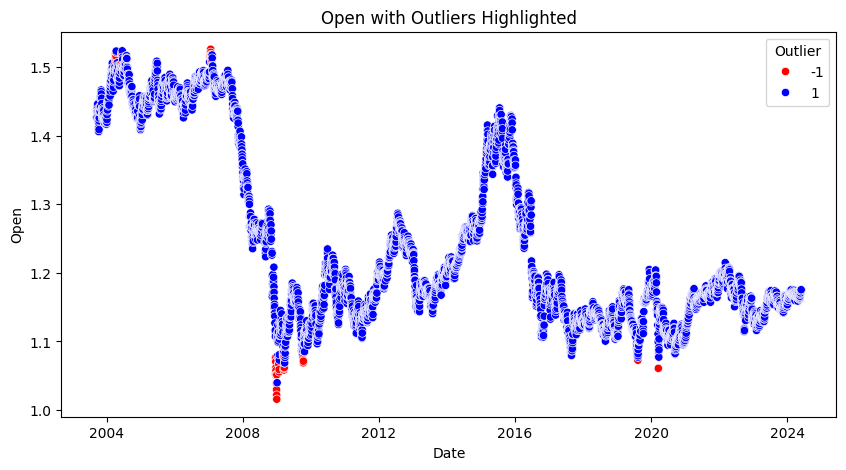

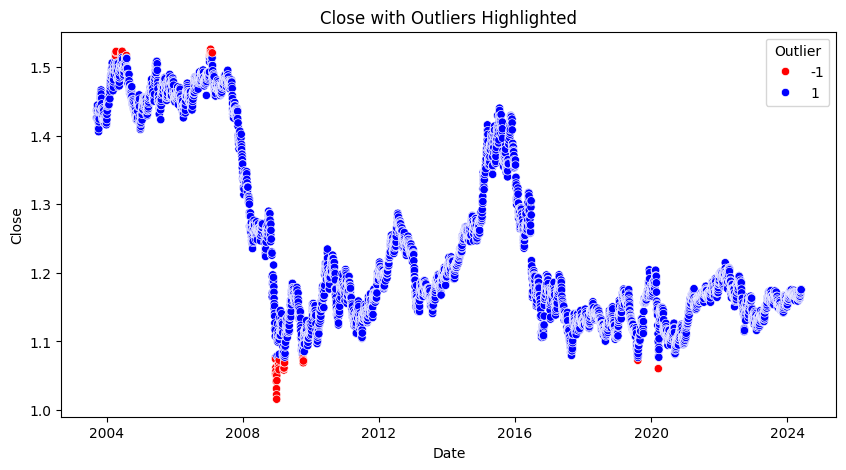

In [ ]:
# Plotting all features to visualize where outliers fall
features = ['Open','Close']
for feature in features:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=df_cleaned, x='Date', y=feature, hue='Outlier', palette={1: 'blue', -1: 'red'})
    plt.title(f'{feature} with Outliers Highlighted')
    plt.show()

In [ ]:
which should I use? ask supervisor

SyntaxError: invalid syntax (<ipython-input-29-64d0050b5091>, line 1)